In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *

import warnings
warnings.filterwarnings('ignore')

## Homework Structure

This homework consists of 3 files:
* [hw4_part1](./hw4_part1.ipynb): It contains an analysis for the first part of the homework. The dataset given contains player-referee dyads and therefore each player appears more than once in the dataset. In our first approach, we keep the dataset as it is, i.e. we do not perform any <code>groupby</code> operation. We remove features that add noise to the dataset and achieve an of 77%.
* [hw4_part1_second_approach](./hw4_part1_second_approach.ipynb): It contains an analysis for the first part of the homework with a second approach on the dataset. More concretely, we do perform a <code>groupby</code> operation using the player name. Achieve a very poor accuracy.
* [hw4_part2](./hw4_part2.ipynb): It contains an analysis for the second part of the homework. More concretely, we perform a <code>groupby</code> operation on the player name and investigate if we can build to separate clusters for white and black soccer player. Our analysis shows that this clustering is not successful.

## Data loading

In [3]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data.shape

(146028, 28)

In [4]:
# first part of loaded data
data.ix[:10,:13].head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0


In [5]:
# second part of loaded data
data.ix[:10,13:28].head()

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


From the given data description, we consider that some features do not carry any information about the skin colour of a player. These features are <code>photoID, playerShort, player, position, Alpha_3, birthday, club</code> and are dropped from the initial dataframe.

In [6]:
drop_features = ['photoID', 'playerShort', 'player', 'position', 'Alpha_3', 'birthday', 'club']
data = data.drop(drop_features, axis=1)
data.shape

(146028, 21)

The skin colour of a player is encoded in the <code>rater1</code> and <code>rater2</code> attributes. Here, we verify that each time <code>rater1</code> has <code>NA</code>, <code>rater2</code> has also <code>NA</code>.

In [7]:
(data['rater1'].isnull() == data['rater2'].isnull()).sum() == data.shape[0]

True

We drop those rows since we do not have any output label.

In [8]:
data.dropna(axis=0,subset=['rater1','rater2'], inplace=True)

In [9]:
columns_with_nan = pd.isnull(data).sum() > 0
columns_with_nan = list(columns_with_nan[columns_with_nan].index)
print(columns_with_nan)

['height', 'weight', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp']


For those columns, we fill the <code>NA</code> values with the median of each column.

In [10]:
for name in columns_with_nan:
    data[name] = fill_nan_values(data[name])

Now, the dataframe does not contain any <code>NA</code> values.

In [11]:
data.isnull().values.any()

False

In order to proceed, we need to convert the <code>leagueCountry</code> into categorical variables with integer encoding.

In [12]:
data['leagueCountry'] = data['leagueCountry'].astype('category')
cat_cols = data.select_dtypes(['category']).columns
data[cat_cols] = data[cat_cols].apply(lambda col : col.cat.codes) 

In [13]:
X = data.drop(['rater1','rater2'], axis=1)

Also, we need to convert the output labels from continuous values to integer numbers, that represent labels. Therefore:
* labels range in the interval[0, 4]
* the higher the value, the darker the skin colour

In [14]:
y = data['rater1'].map({0.0:0,0.25:1,0.5:2,0.75:3,1.0:4})

## Applied Machine Learning

We start by defining a **baseline model**. This model predicts always the most frequent class in our dataset.

In [15]:
y_pred = y.value_counts()

In [16]:
accuracy = np.max(y_pred) / float(np.sum(y_pred))
print(accuracy)

0.399402989865


A naive classifier has an accuracy of 40%.

### Random Forest Classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state=0,class_weight='balanced')
forest.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [22]:
# make prediction on the training set
y_pred = forest.predict(X)

In [23]:
from sklearn import metrics
# measure accuracy of the classifier
metrics.accuracy_score(y,y_pred)

0.98337358872100211

We see that the default RF classifier achieves an accuracy of 98.3% in the <b>training</b> set.

We split the dataset into <b>train</b> and <b>test</b> set. The train and test set are going to be used to fit the model and evaluate the model respectively.

In [24]:
from sklearn.cross_validation import train_test_split
# split test and train size with 40-60% proportion of the initial dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=4)

In [25]:
# train model on the training set
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [26]:
# make predictions
y_pred = forest.predict(X_test)

In [27]:
# get accuracy on test set
metrics.accuracy_score(y_test,y_pred)

0.66470741639752051

Now, wee see that the same classifier achieved an accuracy of 66.8% in the <b>test</b> set.

In [28]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold as cross_validation_KFold
from sklearn.model_selection import KFold as model_selection_KFold

In [29]:
# show importance of each feature
forest.feature_importances_

array([ 0.05404507,  0.22290842,  0.23431589,  0.04717989,  0.04504027,
        0.03397399,  0.03758873,  0.02985269,  0.0290524 ,  0.00275043,
        0.00261151,  0.14549274,  0.02053211,  0.01933182,  0.01481479,
        0.01392349,  0.01800082,  0.0145872 ,  0.01399774])

Feature ranking:
1. feature 2 (0.224956)
2. feature 1 (0.222617)
3. feature 11 (0.167389)
4. feature 3 (0.049865)
5. feature 4 (0.047630)
6. feature 0 (0.043653)
7. feature 6 (0.040341)
8. feature 5 (0.035027)
9. feature 8 (0.032110)
10. feature 7 (0.030196)
11. feature 12 (0.016609)
12. feature 13 (0.015463)
13. feature 16 (0.015438)
14. feature 15 (0.014425)
15. feature 18 (0.013151)
16. feature 17 (0.012556)
17. feature 14 (0.012541)
18. feature 9 (0.003114)
19. feature 10 (0.002919)


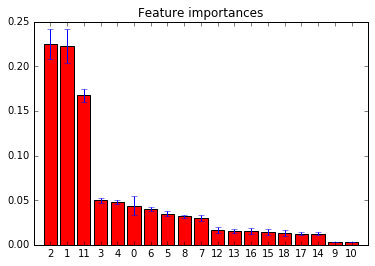

In [25]:
plot_feature_importances(X, forest)
plt.show()

We see that there is a long tail of features with low rank in terms of importance. We prune all features, starting from feature 12, until the end of the tail (features: 12,13,16,15,18,17,14,9,10). We aim at running a new classifier on the reduced dataset and test if the accuracy improves.

In [30]:
features = X.columns.values
# set the importance of the 12th feature as a threshold
threshold = forest.feature_importances_[12]
# find features with importance lower than the threshold
drop_features = [X.columns.values[i] for i in range(len(forest.feature_importances_)) if forest.feature_importances_[i] <= threshold]
print(drop_features)

['yellowReds', 'redCards', 'refCountry', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp']


In [31]:
# remove features with importance lower than the threshold
X = X.drop(drop_features, axis=1)

In [32]:
# test and train set using the new X matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=4)
# train model
forest.fit(X_train, y_train)
# make predictions
y_pred = forest.predict(X_test)
# measure accuracy
metrics.accuracy_score(y_test, y_pred)

0.72372565146743162

We see that the accuracy increases to 74.3% using the dataset with the <b>eliminated features</b>. This indicates that we removed some of the noise contained in the dataset.

## Optimizing the RF classifier

We continue by performing <b>Cross Validation</b> (CV) in order to find the best values for the hyperparameters of the RF classifier, which are:
* number of trees
* depth of trees

In [34]:
scores_trees = []
# train classifier for different number of trees
num_of_trees = [60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260]
for trees in num_of_trees:
    # define cv object
    cv = cross_validation_KFold(X.shape[0], shuffle = True, n_folds=7, random_state=4)
    # initialize classifier
    forest = RandomForestClassifier(n_estimators=trees, random_state=4, n_jobs=-1, class_weight='balanced')
    print('Running 7-fold CV for ' + str(trees) + ' trees...')
    # estimate classifier using CV
    avg_test_accuracy = np.mean(cross_val_score(forest, X, y, cv=cv, scoring='accuracy'))
    scores_trees.append(avg_test_accuracy)
    print(avg_test_accuracy)

Running 7-fold CV for 60 trees...
0.772430007784
Running 7-fold CV for 80 trees...
0.774925574341
Running 7-fold CV for 100 trees...
0.7753187665
Running 7-fold CV for 120 trees...
0.776137248136
Running 7-fold CV for 140 trees...
0.776394026689
Running 7-fold CV for 160 trees...
0.776947705443
Running 7-fold CV for 180 trees...
0.777172386676
Running 7-fold CV for 200 trees...
0.777605700484
Running 7-fold CV for 220 trees...
0.777541505846
Running 7-fold CV for 240 trees...
0.777573603165
Running 7-fold CV for 260 trees...
0.777453238218


Now, we find the number of trees that gave the highest accuracy.

In [35]:
# find the num of trees that gives the best accuracy
max_test_accuracy = np.max(scores_trees)
max_pos = scores_trees.index(max_test_accuracy)
opt_trees = num_of_trees[max_pos]
opt_trees

200

The use the <code>choose_best_model</code> function to find a simpler model that achieved an accuracy $a_s$ such that $$best \ accuracy - a_s < tolerance$$

We do that since we should prefer simpler model, in case the performance between models does not differ significantly.

In [36]:
opt_trees = choose_best_model(scores_trees, num_of_trees, max_test_accuracy, 0.005)
print(opt_trees)

80


Given the optimum number of trees in the forest, we search for the best depth of trees.

In [37]:
scores_depth = []
# possible tree depths
max_depth = [10, 20, 40, 60, 80] 
for depth in max_depth:
    # define cv object
    cv = cross_validation_KFold(X.shape[0],shuffle = True, n_folds=7,random_state=4)
    # initialize classifier
    forest = RandomForestClassifier(n_estimators=opt_trees, max_depth=depth ,random_state=4, n_jobs=-1, class_weight='balanced')
    print('Running 7-fold CV for ' + str(depth) + ' depth...')
    # perform CV to estimate classifier
    avg_test_accuracy = np.mean(cross_val_score(forest, X, y, cv=cv, scoring='accuracy'))
    scores_depth.append(avg_test_accuracy)
    print(avg_test_accuracy)

Running 7-fold CV for 10 depth...
0.513268229271
Running 7-fold CV for 20 depth...
0.771675720785
Running 7-fold CV for 40 depth...
0.773561438281
Running 7-fold CV for 60 depth...
0.774925574341
Running 7-fold CV for 80 depth...
0.774925574341


Now, we find the depth size that gave the highest accuracy.

In [38]:
# find the depth size that gave the highest accuracy.
max_test_accuracy = np.max(scores_depth)
max_pos = scores_depth.index(max_test_accuracy)
opt_depth = max_depth[max_pos]
opt_depth

60

Again, we choose a simpler model.

In [39]:
opt_depth = choose_best_model(scores_depth, max_depth, max_test_accuracy, 0.005)
print(opt_depth)

20


Here, we report the final **accuracy** of our RF classifier with 60 trees and a tree depth of 20.

In [40]:
cv = cross_validation_KFold(X.shape[0],shuffle = True, n_folds=7,random_state=4)
# initialize classifier
forest = RandomForestClassifier(n_estimators=opt_trees, max_depth=opt_depth ,random_state=4, n_jobs=-1, class_weight='balanced')
# perform CV to estimate classifier
avg_test_accuracy = np.mean(cross_val_score(forest, X, y, cv=cv, scoring='accuracy'))
print(avg_test_accuracy)

0.771675720785


### Bonus

Finally, we plot the learning curve for our classifier using the optimum parameters we found after performing CV.

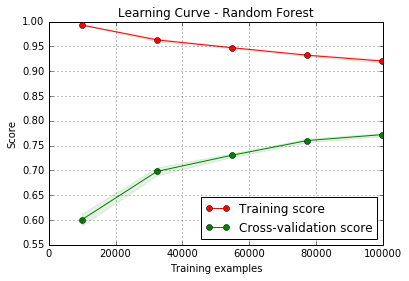

In [41]:
from sklearn.model_selection import learning_curve
forest = RandomForestClassifier(n_estimators=opt_trees, max_depth=opt_depth ,random_state=4, n_jobs=-1, class_weight='balanced')
cv = cross_validation_KFold(X.shape[0],shuffle = True, n_folds=5, random_state=4)
plot_learning_curve(forest, 'Learning Curve - Random Forest', X, y, cv=cv)
plt.show()

We see that the train and test error converge as the size of the training set increases. This kind of learning curve indicates that our model does not suffer from high bias or high variance.
* In case of high bias, the lines of the train and test error become almost parallel as the training size increases.
* In case of high variance, the lines of the train and test error test to converge to each other in a steeper way and there is no evidence that both tend to become parallel.